
<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/Grad_CAM_hard_mode_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we will introduce the Grad-CAM which visualizes the heatmap of input images by highlighting the important region for visual question answering(VQA) task.

* **To be submitted**: this notebook in two weeks, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.

* Make sure you are using the CPU mode in colab, otherwise, you will have some problems. This is important.


In [1]:
import torch
import torch.nn.functional as F
import numpy as np

import torchvision.transforms as transforms
from PIL import Image

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Visual Question Answering problem
Given an image and a question in natural language, the model choose the most likely answer from 3 000 classes according to the content of image. The VQA task is indeed a multi-classificaition problem.
<img src="https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/vqa_model.PNG?raw=1">

We provide you a pretrained model `vqa_resnet` for VQA tasks.

In [2]:
# Download necessary files
%cd /content
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c" -O gradCam.zip && rm -rf /tmp/cookies.txt
! unzip -o gradCam.zip 

/content
--2023-06-08 01:32:04--  https://docs.google.com/uc?export=download&confirm=t&id=1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c
Resolving docs.google.com (docs.google.com)... 172.253.62.102, 172.253.62.100, 172.253.62.113, ...
Connecting to docs.google.com (docs.google.com)|172.253.62.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f58sbscqcqtt0vtideirjpt6mmeod4k7/1686187875000/17628874696062005458/*/1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c?e=download&uuid=9610a5b0-e7fc-4db2-9598-60c68b02516c [following]
--2023-06-08 01:32:04--  https://doc-04-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f58sbscqcqtt0vtideirjpt6mmeod4k7/1686187875000/17628874696062005458/*/1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c?e=download&uuid=9610a5b0-e7fc-4db2-9598-60c68b02516c
Resolving doc-04-94-docs.googleusercontent.com (doc-04-94-docs.googleusercontent.com)... 142.251

In [3]:
# load model
%cd /content/gradCam
from load_model import load_model
vqa_resnet = load_model()

/content/gradCam


Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to /root/.cache/torch/hub/checkpoints/resnet152-95e0e999.pth
100%|██████████| 230M/230M [00:01<00:00, 156MB/s]


In [4]:
print(vqa_resnet) # for more information 

VQA_Resnet_Model(
  (text): TextProcessor(
    (embedding): Embedding(15193, 300, padding_idx=0)
    (drop): Dropout(p=0.5, inplace=False)
    (tanh): Tanh()
    (lstm): LSTM(300, 1024)
  )
  (attention): Attention(
    (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (q_lin): Linear(in_features=1024, out_features=512, bias=True)
    (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
    (drop): Dropout(p=0.5, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (classifier): Classifier(
    (drop1): Dropout(p=0.5, inplace=False)
    (lin1): Linear(in_features=5120, out_features=1024, bias=True)
    (relu): ReLU()
    (drop2): Dropout(p=0.5, inplace=False)
    (lin2): Linear(in_features=1024, out_features=3000, bias=True)
  )
  (resnet_layer4): ResNetLayer4(
    (r_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [5]:
checkpoint = '2017-08-04_00.55.19.pth'
saved_state = torch.load(checkpoint, map_location=device)
# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx]=w

### Inputs
In order to use the pretrained model, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(448, 448)`. You can call the function `image_to_features` to achieve image preprocessing. For input question, the function `encode_question` is provided to encode the question into a vector of indices. You can also use `preprocess` function for both image and question preprocessing.

In [14]:
def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

In [19]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0) # token_to_index : dict of questions tokens
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)

In [15]:
# preprocess requires the dir_path of an image and the associated question. 
#It returns the spectific input form which can be used directly by vqa model. 
def preprocess(dir_path, question):
    q, q_len = encode_question(question)
    img = Image.open(dir_path).convert('RGB')
    image_size = 448  # scale image to given size and center
    central_fraction = 1.0
    transform = get_transform(image_size, central_fraction=central_fraction)
    img_transformed = transform(img)
    img_features = img_transformed.unsqueeze(0).to(device)
    
    inputs = (img_features, q.unsqueeze(0), q_len.unsqueeze(0))
    return inputs

We provide you two pictures and some question-answers.

[33, 30]


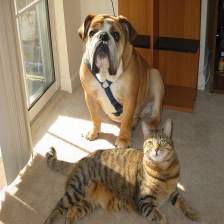

In [17]:
Question1 = 'What animal'
Answer1 = ['dog','cat' ]
indices1 = [answer_to_index[ans] for ans in Answer1]# The indices of category 
img1 = Image.open('dog_cat.png')
print(indices1)
img1

In [20]:
dir_path = 'dog_cat.png' 
inputs = preprocess(dir_path, Question1)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).data.cpu().numpy())
print(answer_words[answer_idx])

dog


In [24]:
# Tokenized question : token_to_index["what"] = 3, token_to_index["animal"] = 32
print(inputs[1])
print(inputs[2]) # number of words in the question 

tensor([[ 3, 32]])
tensor([2])


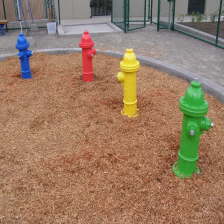

In [25]:
Question2 = 'What color'
Answer2 = ['green','yellow' ]
indices2 = [answer_to_index[ans] for ans in Answer2]
img2 = Image.open('hydrant.png')
img2

In [26]:
dir_path = 'hydrant.png' 
inputs = preprocess(dir_path, Question2)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).data.cpu().numpy())
print(answer_words[answer_idx])
print(inputs[1], inputs[2])

green
tensor([[ 3, 12]]) tensor([2])


### Grad-CAM 
* **Overview:** Given an image with a question, and a category (‘dog’) as input, we foward propagate the image through the model to obtain the `raw class scores` before softmax. We backpropagate only the logit of the target class. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the two images. For each image, consider the answers we provided as the desired classes. Compare the heatmaps of different answers, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model `vqa_resnet` doesn't have the activation function after its last layer, the output is indeed the `raw class scores`, you can use it directly. Run "print(vqa_resnet)" to get more information on VGG model.
 + The last CNN layer of the model is: `vqa_resnet.resnet_layer4.r_model.layer4[2].conv3` 
 + The size of feature maps is 14x14, so as your heatmap. You need to project the heatmap to the original image(224x224) to have a better observation. The function `cv2.resize()` may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

We apply a ReLU to the linear combination of maps because we are only interested in the features that have a positive influence on the class of interest, i.e. pixels whose intensity should be increased in order to increase y^c.

<img src="https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/grad_cam.png?raw=1">

In [42]:
# The forward hook will be executed when a forward call is executed. 
output_saving = 0
grad_output_saving = 0

def forward_hook(self, input, output):
  global output_saving
  # List of size 1 containing a tensor of size (1, C, H, W)
  output_saving = output

def backward_hook(self, grad_input, grad_output):
    global grad_output_saving
    # List of size 1 containing a tensor of size (1, C, H, W)
    grad_output_saving = grad_output

# What does global means in python?
# Why do we need global?
## Hooks cannot return anything so need to save them somehow, e.g. global variables

## The output shape of CNN Conv2d is (N,C,H,W)
## Here (H,W) : feature map size (14,14), C: 2048

In Figure 2, the activations from the "Rectified Conv Feature Maps" (A) are sent to a "Visual Question Answering" network (bottom right). We need to backpropagate the gradients (blue arrow) to "Guided backpropagation" and "Backprop till conv". 

In [43]:
# We need to record the output and grad_output of the feature maps to achieve Grad-CAM. 

vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_forward_hook(forward_hook)
vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_backward_hook(backward_hook)

In [52]:
import cv2 

def gradCAM(dir_path = 'dog_cat.png' , Question = 'What animal', answer = "dog"):
    img = Image.open(dir_path)
    fig, axs = plt.subplots(1,3,figsize=(15,6))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")

    inputs = preprocess(dir_path, Question)
    vqa_resnet.zero_grad()
    ans = vqa_resnet(*inputs) # shape : torch.Size([1, 3000])

    # Backpropagating just on the dog or the given answer
    vqa_resnet.zero_grad()
    # raw class score of the true label class
    only_ans_class = ans[0,answer_to_index[answer]]
    ## we first compute the gradient of the score for class c, (before the softmax), 
    ## wrt feature map activations Ak of a convolutional layer, i.e. ∂yc/∂Ak .
    only_ans_class.backward() # gradient of class score

    # Construction of the grad_cam map
    grad_cam = torch.zeros_like(output_saving[0,0,:,:]) # [14,14]
    nb_features = output_saving[0].size()[0] # 2048

    print(len(grad_output_saving), grad_output_saving[0].shape) # tuple, [1,2048,14,14]

    for i in range(nb_features):
        # We take the mean of each feature of the gradient multiplied by the output
        # use output_saving and grad_output_saving to complete the following line.
        # You have to understand eq. 1 and 2 in the paper.
        alpha = torch.mean(grad_output_saving[0][0,i]) # global average pooling
        grad_cam += output_saving[0][i] * alpha


    Relu = torch.nn.ReLU()
    grad_cam = Relu(grad_cam)
    grad_cam = grad_cam.detach().numpy()

    cam = cv2.resize(grad_cam, (224,224))
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
    cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize

    # Heatmap of activation map
    activation_heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_HSV)
    axs[1].imshow(activation_heatmap)
    axs[1].set_title("Heatmap of activation map")

    # Heatmap on picture
    img = cv2.imread(dir_path)
    org_img = cv2.resize(img, (224, 224))
    img_with_heatmap = np.float32(activation_heatmap) + np.float32(org_img)
    img_with_heatmap *= 0.99/ np.max(img_with_heatmap)
    axs[2].imshow(img_with_heatmap)
    axs[2].set_title("Heatmap on picture")

    plt.show()

1 torch.Size([1, 2048, 14, 14])


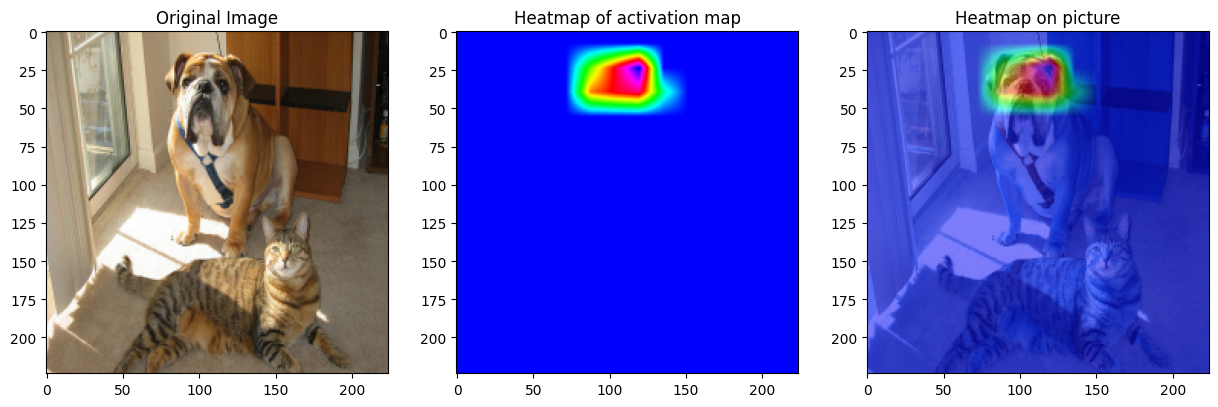

In [53]:
gradCAM(dir_path = 'dog_cat.png' , Question = 'What animal', answer = "dog")

1 torch.Size([1, 2048, 14, 14])


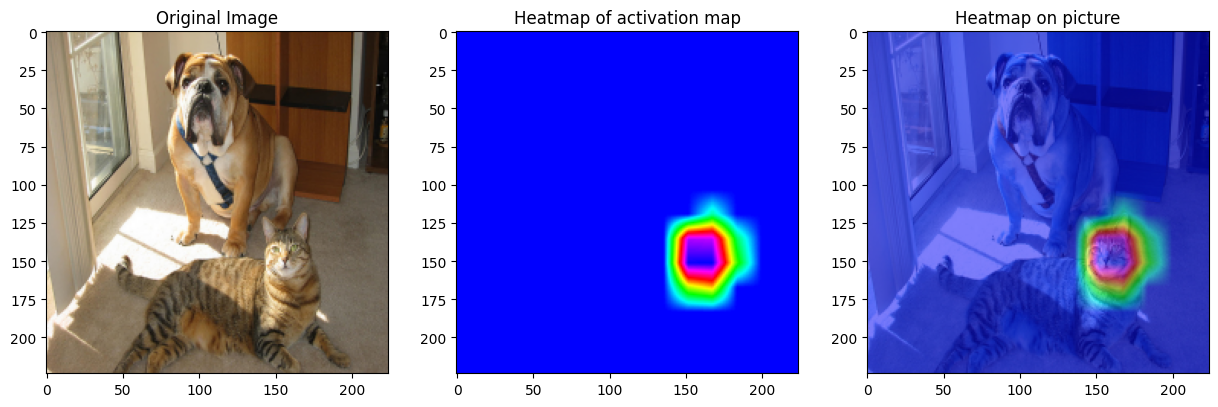

In [54]:
gradCAM(dir_path = 'dog_cat.png' , Question = 'What animal', answer = "cat")

1 torch.Size([1, 2048, 14, 14])


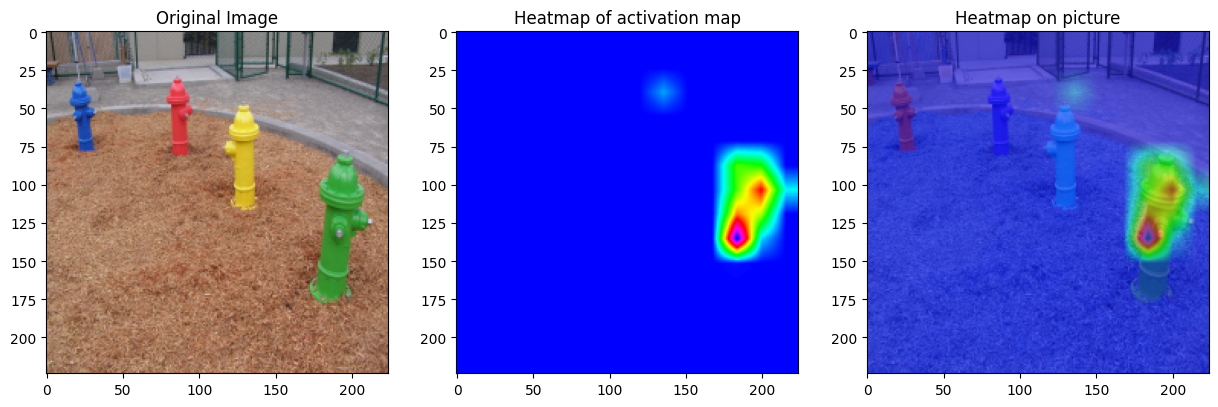

In [55]:
gradCAM(dir_path = 'hydrant.png' , Question = 'What color', answer = "green")


1 torch.Size([1, 2048, 14, 14])


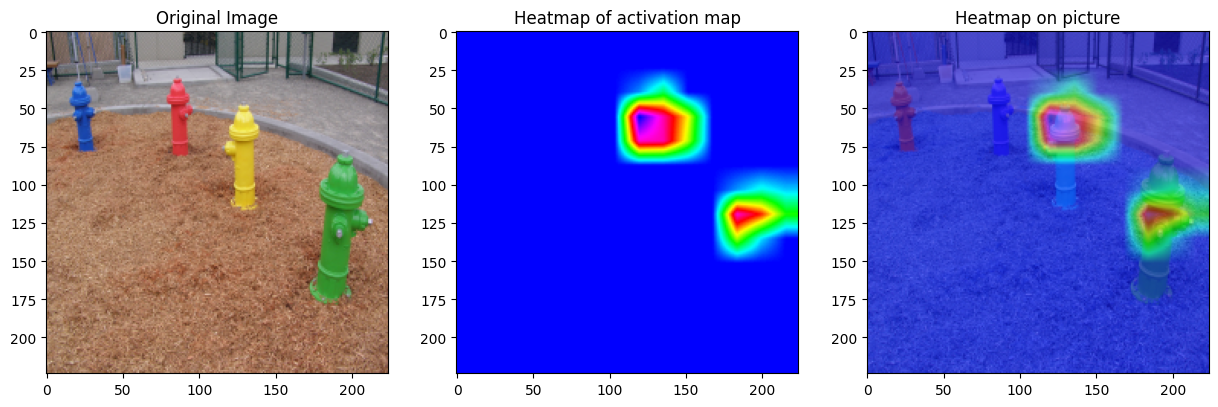

In [56]:
gradCAM(dir_path = 'hydrant.png' , Question = 'What color', answer = "yellow")

Other repos : 

https://github.com/ashutosh1919/explainable-cnn/tree/main